# Киташов Федор, 514 группа. Домашнее задание 4. 

In [7]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import trange

In [10]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [11]:
from util import load_mnist

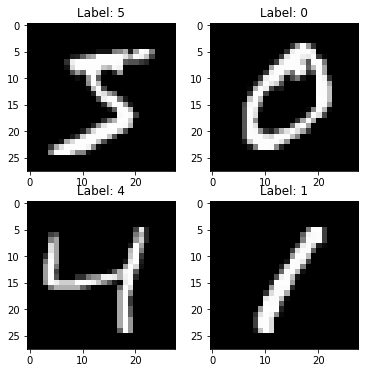

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [13]:
class Net(nn.Module):
    def __init__(self, hidden_size=40):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)

In [15]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [17]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure(figsize=(16,9))
    plt.plot(train_history, label='train')
    val_step = len(X_train) // batchsize
    plt.plot([val_step * x for x in range(1, len(train_history) // val_step + 1)], val_history, 'y+', label='val',
             markeredgewidth=2, markersize=20)
    plt.gca().set_ylim([0.0, 1.2])
    plt.legend(loc='best')
    plt.title('{} at {} epoch'.format(title, epoch))
    plt.xlabel('train steps')
    plt.grid()
    plt.show()

# Буду выводить график ошибки и точности за батч:

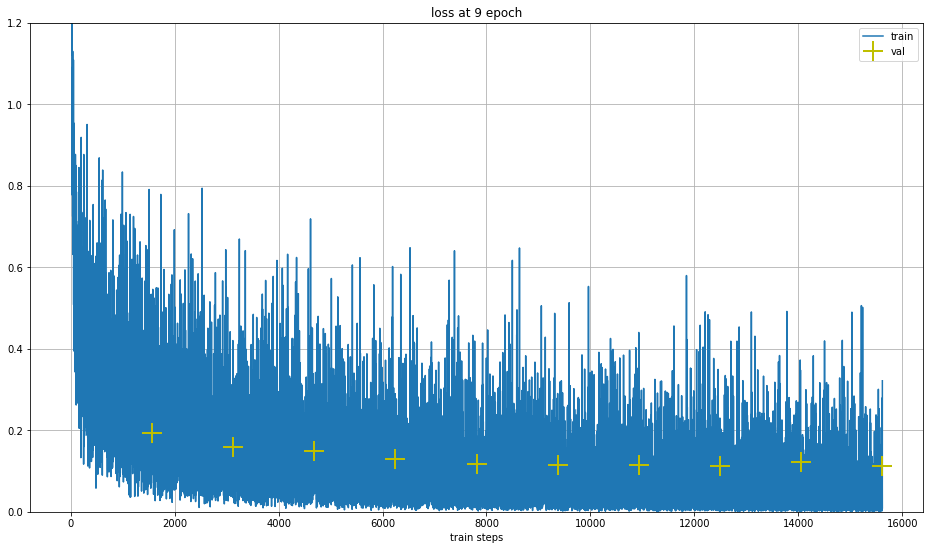

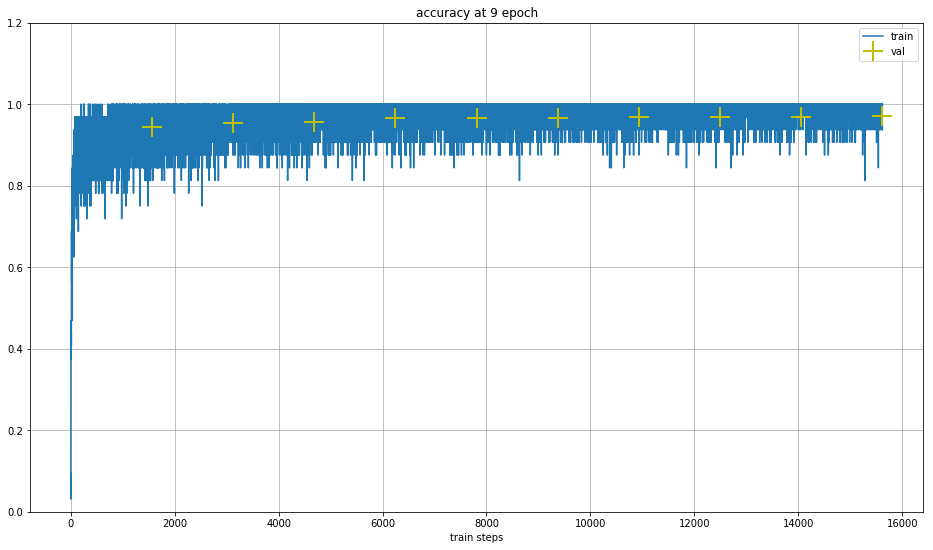

In [19]:
def train(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = Variable(torch.from_numpy(x_batch.astype(np.float32)))
        target = Variable(torch.from_numpy(y_batch.astype(np.int64)))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        pred = output.data.max(1, keepdim=True)[1]
        target_matches = torch.eq(pred, target.data.view(len(data), 1))
        loss_acc = torch.sum(target_matches) / len(data)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.data[0]
        loss_log.append(loss)
        acc_log.append(loss_acc)
    return loss_log, acc_log


def test(model):
    loss_log, acc_log = [], []
    
    model.eval()
    
    data = Variable(torch.from_numpy(X_val.astype(np.float32)))
    target = Variable(torch.from_numpy(y_val.astype(np.int64)))
    
    output = model(data)
    loss = F.nll_loss(output, target)
    
    pred = output.data.max(1, keepdim=True)[1]
    target_matches = torch.eq(pred, target.data.view(len(data), 1))
    loss_acc = torch.sum(target_matches) / len(data)
    
    loss_log.append(loss)
    acc_log.append(loss_acc)
    
    return loss_log, acc_log


train_log, train_acc_log = [], []
val_log, val_acc_log = [], []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32
    
for epoch in range(10):
    train_loss, train_acc_loss = train(model, opt)
    
    val_loss, val_acc_loss = np.mean(test(model)[0]).data.numpy(), test(model)[1]
    
    train_log.extend(train_loss)
    train_acc_log.extend(train_acc_loss)
    val_log.extend(val_loss)
    val_acc_log.extend(val_acc_loss)
    
    clear_output()
    plot_history(train_log, val_log)
    plot_history(train_acc_log, val_acc_log, title='accuracy')
    